# Clustering examples

This notebook is for developing the fuzzy clustering package and demonstrating how to use it with scikit-learn.

The basic idea is that we create some scikit-learn compatible clustering estimators and a group of scoring functions. They can then be thrown about using scikit-learn for the following important purposes.

* [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) : Chain together pre-processing, clustering and scoring steps into one object
* [Model evaluation](https://scikit-learn.org/stable/model_selection.html#model-selection) : Cross validation of models to find optimum fitting parameters as scored against various scoring functions

We aim to build clustering estimators and store them in ./Models and maybe add:

* Ensemble methods (run many times to assess stability)
* I/O helper functions (read csv, netcdf, whatever)
* Suite of scoring metrics (silouette score, fuzzy partition matrix, etc)
* Default, pretrained models (one for each common dataset, like OLCI, OC-CCI etc)

in a way that is generalised to work on all models. Must be a scikit-learn compatible object and must not reinvent wheels here

In [1]:
import sys
sys.path.append("./Estimators/")

In [2]:
from cmeans_python import CmeansModel

In [3]:
from sklearn.datasets import make_blobs
import pandas as pd
# import hvplot.pandas
# import holoviews as hv
import xarray as xr
# import hvplot.xarray
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

## Create a blobby dataset

In [4]:
blobs, labels = make_blobs(n_samples=2000, n_features=2)

In [5]:
df = pd.DataFrame(blobs, columns=['x','y'])

<Figure size 432x288 with 0 Axes>

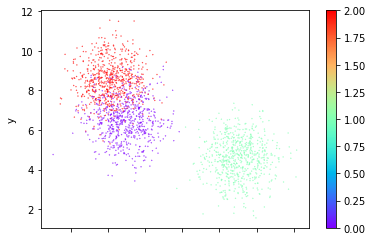

In [6]:
plt.figure()
df.plot.scatter(x='x', y='y', c=labels, s=0.1, cmap='rainbow')
plt.show()

In [7]:
# df.hvplot(kind='scatter',x='x',y='y',c=labels, cmap='rainbow') * hv.Points(cmeans.cntr_)

In [8]:
cmeans = CmeansModel(c=3)

In [12]:
cmeans.fit(blobs)

CmeansModel(c=3, err=0.005, m=2, maxiter=1000)

In [15]:
cmeans.u_.shape

(3, 2000)

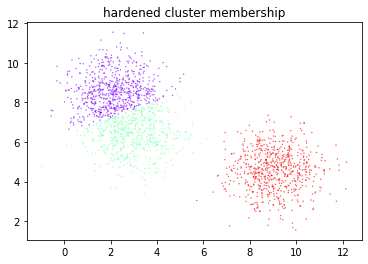

In [37]:
plt.figure()
plt.scatter(
    *blobs.T,
    c=cmeans.labels_,
    s=0.1,
    cmap='rainbow'
)
plt.title('hardened cluster membership')
plt.show()

## Performance metrics

if an algorithm comes with its own scoring metric that will be class specific. However, we can get some metrics that are applicable across all methods. 

Scikit-learn has a [suite of metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

Probably the best way is to make a scorer object from a scoring function with `sklearn.metrics.make_scorer` which can be placed at after clustering in a pipeline which is then fed to a GridSearch like object.

In [27]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score, contingency_matrix, normalized_mutual_info_score, silhouette_samples, silhouette_score

In [28]:
metrics = [adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score, contingency_matrix, normalized_mutual_info_score, silhouette_samples, silhouette_score]

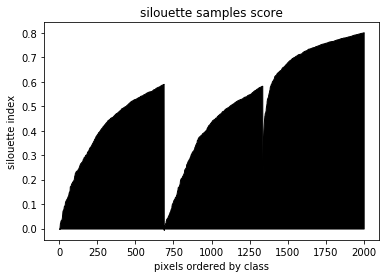

In [39]:
ss = silhouette_samples(df, cmeans.labels_)

# hv.Bars(
#     np.hstack([sorted(ss[cmeans.labels_==i]) for i in range(3)])
# )

plt.figure()
plt.fill_between(
    np.arange(len(df)),
    np.zeros(len(df)),
    np.hstack([sorted(ss[cmeans.labels_==i]) for i in range(3)]),
    color='black',
)
plt.title('silouette samples score')
plt.ylabel('silouette index')
plt.xlabel('pixels ordered by class')
plt.show()

In [40]:
from sklearn.metrics import pairwise_distances

In [41]:
from sklearn.metrics import make_scorer

In [42]:
from sklearn.metrics import pairwise_distances, silhouette_score

def xie_beni(Estimator, X, y=None):
    """ Xie-Beni scoring function
        for cmeans.
        
        Output is negative as scikit-learn
        by default maximizes scores """
    
    u = Estimator.predict(X)
    v = Estimator.cntr_
    m = Estimator.m
    
    n = X.shape[0]
    c = v.shape[0]

    um = u**m
    
    d2 = pairwise_distances(X, v)
    v2 = pairwise_distances(v, v)
    
    v2[v2 == 0.0] = np.inf
   
    return np.sum(um.T*d2)/(n*np.min(v2))

def hard_silouette(Estimator, X, y=None):
    """ A hard silouette scoring function
        for clustering algorithms. Built on
        `sklearn.metrics.silhouette_score`
        
        Uses np.argmax() to convert soft
        clusters into hard clusters prior
        to evaluation."""
        
    u = Estimator.predict(X)
    if u.shape != X.shape[0]:
        u = np.argmax(u, axis=0)

    return silhouette_score(X, u)

In [43]:
# FIXME : WOULD A DECORATOR FUNCTION SUFFICE HERE?

def hard_silouette(Estimator, X, y=None):
    """ A hard silouette scoring function
        for clustering algorithms. Built on
        `sklearn.metrics.silhouette_score`
        
        Uses np.argmax() to convert soft
        clusters into hard clusters prior
        to evaluation."""
        
    u = Estimator.predict(X)
    if u.shape != X.shape[0]:
        u = np.argmax(u, axis=0)

    return silhouette_score(X, u)

def fuzzy_partition_coef(Estimator, X, y=None):
    """ Fuzzy partion coefficient (fpc) 
        for fuzzy clustering algorithms"""
    
    u = Estimator.predict(X)
    return Estimator.fpc_

def calinski_harabasz(Estimator, X, y=None):
    """ Fuzzy partion coefficient (fpc) 
        for fuzzy clustering algorithms"""
    
    u = Estimator.predict(X)
    
    if u.shape != X.shape[0]:
        u = np.argmax(u, axis=0)

    return calinski_harabasz_score(X, u)


def davies_bouldin(Estimator, X, y=None):
    """ Fuzzy partion coefficient (fpc) 
        for fuzzy clustering algorithms"""
    
    u = Estimator.predict(X)
    
    if u.shape != X.shape[0]:
        u = np.argmax(u, axis=0)
    
    return -davies_bouldin_score(X, u)

# Grid search of fitting parameters by cross validation

In [44]:
from sklearn.model_selection import cross_validate, GridSearchCV

In [45]:
scoring = {
    'XB': xie_beni,
    'SIL': hard_silouette,
    'FPC': fuzzy_partition_coef,
#     'CH': calinski_harabasz,
    'DB': davies_bouldin,
}

gs = GridSearchCV(cmeans,
                  param_grid={'c': range(2,10), 'm':[1.1,1.5,2.0,2.5,3.0]},
                  scoring=scoring, refit='SIL')
gs.fit(df, None)
results = gs.cv_results_

/Users/Angus_Laurenson/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [46]:
dfr = pd.DataFrame(results)

# Visualisation of results with `hvplot`

### Scores on the doors

In [47]:
dfr['mean_total_score'] = dfr[[f'mean_test_{x}' for x in scoring.keys()]].mean(axis=1)

In [57]:
dsr = xr.Dataset.from_dataframe(dfr.groupby(['param_c','param_m']).mean())

In [62]:
dsr[[f'mean_test_{x}' for x in scoring.keys()] + ['mean_total_score']].to_array(dim='scores')

<xarray.DataArray (scores: 5, param_c: 8, param_m: 5)>
array([[[ 0.21018755,  0.20634864,  0.18407202,  0.14994316,
          0.11587094],
        [ 0.83143487,  0.45984009,  0.37248064,  0.26809121,
          0.17928751],
        [ 0.63507969,  0.58190735,  0.44061887,  0.28763961,
          0.17167736],
        [ 0.57631667,  0.53756013,  0.3736593 ,  0.22589189,
          0.12040215],
        [ 0.55713812,  0.48917094,  0.31902849,  0.17810898,
          0.0878215 ],
        [ 0.52626739,  0.41527707,  0.288478  ,  0.14540208,
          0.06694766],
        [ 0.50346928,  0.41892127,  0.25337159,  0.12648178,
          0.05745957],
        [ 0.53389388,  0.43194553,  0.24596992,  0.11204813,
          0.0443694 ]],

       [[ 0.70491152,  0.70482017,  0.70482017,  0.70482017,
          0.70482017],
        [ 0.52973358,  0.50309125,  0.50301836,  0.50279592,
          0.5026592 ],
        [ 0.38579772,  0.42604258,  0.37999912,  0.38216255,
          0.38208198],
        [ 0.41736661,  0.31333549,  0.30482059,  0.32066816,
          0.33932689],
        [ 0.3187675 ,  0.31694659,  0.30865046,  0.31193567,
          0.31189596],
        [ 0.32504608,  0.32917123,  0.31375201,  0.31340829,
          0.31099484],
        [ 0.31710966,  0.32647458,  0.31370589,  0.30769078,
          0.30246353],
        [ 0.30808585,  0.31446226,  0.30572872,  0.30562317,
          0.30253742]],

       [[ 0.99947484,  0.9823167 ,  0.90377583,  0.80782489,
          0.73023363],
        [ 0.98774469,  0.90177524,  0.7542005 ,  0.62516406,
          0.53623929],
        [ 0.97495314,  0.84441242,  0.65898934,  0.51835278,
          0.42953141],
        [ 0.97477201,  0.79451195,  0.58095495,  0.4448908 ,
          0.35526589],
        [ 0.9651693 ,  0.7804488 ,  0.54797611,  0.39993424,
          0.31326878],
        [ 0.96644031,  0.77210025,  0.52059054,  0.36445913,
          0.27792606],
        [ 0.96248771,  0.76204241,  0.50008801,  0.33792298,
          0.25147293],
        [ 0.96263842,  0.75331245,  0.48370184,  0.31927459,
          0.23231671]],

       [[-0.40398312, -0.40434498, -0.40434498, -0.40434498,
         -0.40434498],
        [-1.04888658, -0.77382545, -0.77407098, -0.77425103,
         -0.77431246],
        [-1.07944285, -0.95375111, -1.06872864, -1.06947779,
         -1.06582066],
        [-0.87684355, -1.16076906, -1.18126619, -1.11717513,
         -1.07170226],
        [-1.0512482 , -1.06778681, -1.10017249, -1.12918863,
         -1.08823258],
        [-0.94713769, -0.9260982 , -1.04646081, -1.03358369,
         -1.03497212],
        [-0.97099179, -0.94137033, -0.98059196, -0.99824392,
         -1.01893704],
        [-0.9836493 , -0.95306696, -0.97381695, -0.96984437,
         -0.97786369]],

       [[ 0.3776477 ,  0.37228513,  0.34708076,  0.31456081,
          0.28664494],
        [ 0.32500664,  0.27272028,  0.21390713,  0.15545004,
          0.11096839],
        [ 0.22909693,  0.22465281,  0.10271967,  0.02966929,
         -0.02063248],
        [ 0.27290293,  0.12115963,  0.01954216, -0.03143107,
         -0.06417683],
        [ 0.19745668,  0.12969488,  0.01887064, -0.05980244,
         -0.09381159],
        [ 0.21765402,  0.14761259,  0.01908993, -0.05257855,
         -0.09477589],
        [ 0.20301871,  0.14151698,  0.02164338, -0.05653709,
         -0.10188525],
        [ 0.20524221,  0.13666332,  0.01539588, -0.05822462,
         -0.09966004]]])
Coordinates:
  * param_c  (param_c) int64 2 3 4 5 6 7 8 9
  * param_m  (param_m) float64 1.1 1.5 2.0 2.5 3.0
  * scores   (scores) <U16 'mean_test_XB' 'mean_test_SIL' ... 'mean_total_score'

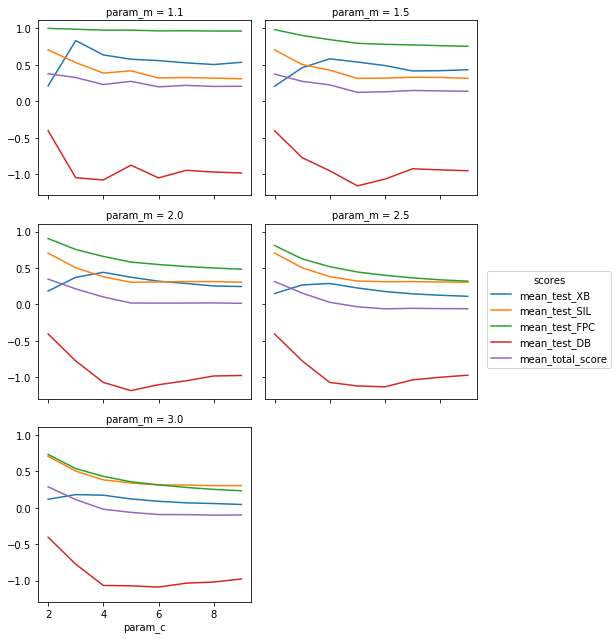

In [65]:
dsr[[f'mean_test_{x}' for x in scoring.keys()] + ['mean_total_score']].to_array(dim='scores').plot.line(
    x='param_c',
    hue='scores',
    col='param_m',
    col_wrap=2
)

In [48]:
dfr.hvplot(
    groupby=['param_m'],
    x='param_c',
    y=[f'mean_test_{x}' for x in scoring.keys()] + ['mean_total_score']
)

AttributeError: 'DataFrame' object has no attribute 'hvplot'

### Scatter plot dominant class

In [ ]:
df.hvplot(kind='scatter',x='x',y='y',c=np.argmax(gs.predict(df),axis=0), cmap='rainbow') * hv.Points(gs.best_estimator_.cntr_)

In [ ]:
dfu = pd.DataFrame(gs.best_estimator_.u_.T, columns=[f'cluster {x}' for x in range(gs.best_estimator_.u_.shape[0])])

In [ ]:
dfu.hvplot(kind='hist', bins=100, 
           width=500, 
#            subplots=True,
           alpha=1/gs.best_estimator_.u_.shape[0]
          )